In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 텐서플로우
* 수치 계산을 위한 강력한 오픈소스 SW 라이브러리
* 계산 그래프를 여러 부분으로 나누어 여러 CPU나 GPU에서 병렬로 실행할 수 있다.
* 분산 컴퓨팅도 지원하므로 수백 대의 서버에 계산을 나누어 납득할만한 시간 안에 대규모 데이터셋으로 거대한 신경을 훈련시킬 수 있다.
* 수백만 개의 특성을 가진 수십억 개의 샘플로 구성된 데이터셋에서 수백만 개의 파라미터를 가진 네트워크를 훈련시킬 수 있다.

# 1. 계산 그래프 만들어 세션에서 실행하기

In [22]:
reset_graph()

x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = x*x*y + y + 2
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

* 코드가(특히 마지막 줄) 계산을 하는 것처럼 보이지만 실제로 어떤 계산도 수행하지 않는다. 단지 계산 그래프만 만든다. 사실 변수조차도 초기화되지 않는다.
* 이 계산 그래프를 평가하려면 텐서플로 세션을 시작하고 변수를 초기화한 다음 `f`를 평가해야 한다.
> **평가**  
계산 그래프나 노드를 실행(run, execute)하여 연산의 값을 계산한다는 의미
* 세션은 연산을 CPU나 GPU같은 장치에 올리고 실행하는 것을 도와주며 모든 변숫값을 가지고 있다. (텐서플로 분산 환경에서는 변숫값이 세션이 아니라 서버에 저장된다)

#### 세션을 만들고 변수 초기화한 다음 `f`를 평가하고 세션 닫기(즉, 자원 해제)

In [23]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


#### 매번 실행하는 `sess.run()` 반복을 해소하는 방법(단순화)

In [24]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

> * `with` 블록 안에서는 `with`문에서 선언한 세션이 기본 세션으로 지정된다.
* `x.initializer.run()` : `tf.get_default_session().run(x.initializer)` 호출하는 것과 동일
* `f.eval()` : `tf.get_default_session().run(f)` 호출하는 것과 동일
    * `tf.Operation` 객체 (`x.initializer`와 같은) : `run()` 메서드 사용
    * `tf.Tensor` 객체 : `eval()` 메서드 사용
        * 실제 `eval()` 메서드에서 하는 작업 : 디폴트 세션의 `run()` 메서드 호출
* 세션은 `with` 블록이 끝나면 자동으로 종료된다.

* 각 변수의 초기화를 일일히 실행하는 대신 `global_variables_initializer()` 함수를 사용할 수 있다.
* 이 함수는 초기화를 바로 수행하지 않고 계산 그래프가 실행될 때 모든 변수를 초기화할 노드를 생성한다.

In [25]:
init = tf.global_variables_initializer() # init 노드 준비

with tf.Session() as sess:
    init.run() # 실제 모든 변수 초기화
    result = f.eval()

* 주피터나 파이썬 셸에서는 `InteractiveSession`을 만드는 편이 편리할 수 있다.
* 일반적인 `Session`과 다른 점 : `InteractiveSession`이 만들어질 때 자동으로 자신을 기본 세션으로 지정한다.
    * 그러므로 `with` 블록을 사용할 필요가 없다.
    * 대신 사용이 끝났을 때는 수동으로 세션을 종료해주어야 한다.

In [26]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

42


## 1.1. 텐서플로 프로그램 구성
텐서플로 프로그램은 두 부분으로 나뉜다.
* **구성 단계** : 계산 그래프를 만든다.
    * 훈련에 필요한 계산과 머신러닝 모델을 표현한 계산 그래프를 만든다.
* **실행 단계** : 이 그래프를 실행한다.
    * 훈련 스텝을 반복해서 평가하고(예를 들면 미니배치마다 한 스텝씩), 모델 파라미터를 점진적으로 개선하기 위해 반복 루프를 수행한다.

# 2. 계산 그래프 관리
노드를 만들면 자동으로 기본 계산 그래프에 추가된다.

In [27]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

대부분의 경우 이것으로 충분하지만 독립적인 그래프를 여러 개 만들 경우가 생긴다.  
이 때는 새로운 Graph 객체를 만들어 `with` 블록 안에서 임시로 이를 기본 계산 그래프로 사용할 수 있다.

In [28]:
graph = tf.Graph()

with graph.as_default():
    x2 = tf.Variable(2)
    
x2.graph is graph

True

In [29]:
x2.graph is tf.get_default_graph()

False

> **TIP**  
주피터 (또는 파이썬 셸)에서 실험적인 작업을 하는 동안에는 같은 명령을 여러 번 실행하는 경우가 많다.  
이렇게 하면 기본 그래프에 중복된 노드가 많이 포함된다.  
주피터 커널 (또는 파이썬 셸)을 다시 시작하는 것이 한 가지 해법이지만, 더 편리한 방법은 `tf.reset_default_graph()`로 기본 그래프를 초기화해주는 것이다.

# 3. 노드 값의 생애주기
한 노드를 평가할 때 텐서플로는 이 노드가 의존하고 있는 다른 노드들을 자동으로 찾아 먼저 평가한다.
> * 텐서플로 변수는 초기화를 위한 노드가 따로 있다.
* `tf.constant`로 만들어진 상수는 노드 자체에 값을 지니고 있으며 변경 불가능하다.

1. 매우 간단한 그래프를 정의한 다음 세션을 시작하고 `y`를 평가하기 위해 계산 그래프를 실행한다.
    * 텐서플로는 자동으로 `y`가 `x`에 의존한다는 것과 `x`가 `w`에 의존한다는 것을 감지한다.  
2. 먼저 `w`를 평가하고 그 다음에 `x`를, 그 다음에 `y`를 평가해서 `y`값을 반환한다.
3. 마지막으로 `z`를 평가하기 위해 그래프를 실행한다.
4. 다시 한번 텐서플로는 먼저 `w`와 `x`를 평가해야 한다는 것을 감지한다.
    * 이 때 이전에 평가된 `w`와 `x`를 재사용하지 않는다.
    * 즉 위 코드는 `w`와 `x`를 두 번 평가한다.

In [30]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

10
15


* 모든 노드의 값은 계산 그래프 실행 간에 유지되지 않는다.
* 변숫값은 예외로, 그래프 실행 간에도 세션에 의해 유지된다(큐(queue)와 리더(reader)도 일부 상태를 유지한다(12장 참고)).
* 변수는 초기화될 때 일생이 시작되고 세션이 종료될 때까지 남아있다.

#### 효율적으로 평가하기
* 이전 코드처럼 `w`와 `x`를 두 번 평가하지 않고 `y`와 `z`를 효율적으로 평가하려면 한 번의 그래프 실행에서 `y`와 `z`를 모두 평가하도록 만들어야 한다.

In [31]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
15


> **CAUTION**  
* 단일 프로세스 텐서플로 : 같은 그래프를 재사용하더라도 여러 세션에서 어떤 상태도 공유하지 않는다.
    * 각 세션은 모든 변수에 대해 고유한 복사본을 가진다.
* 분산 텐서플로 : 변수 상태가 세션이 아니라 서버에 저장되므로 여러 세션이 같은 변수를 공유할 수 있다.

# 4. 텐서플로를 이용한 선형 회귀
* 텐서플로 연산(operation, 줄여서 ops) : 여러 개의 입력을 받아 출력을 만들 수 있다.
* 소스 연산(source ops) : 상수와 변수 연산은 입력이 없다. 이러한 것
* 입력과 출력은 **텐서**(tensor)라는 다차원 배열이다.
* 텐서는 데이터타입과 크기를 가지며 파이썬 API에서 텐서는 Numpy `ndarray`로 나타난다.
> 텐서를 평가한 결과가 Numpy 배열로 반환된다.
* 보통은 실수로 채워지지만 문자열(임의의 바이트 배열)을 저장할 수도 있다.

#### 스칼라가 아닌 배열을 가지는 텐서의 연산
캘리포니아 주택 가격 데이터셋에 선형회귀를 수행하기 위해 2D 배열을 다루기
1. 먼저 데이터셋을 추출하고 모든 훈련 샘플에 편향에 대한 입력 특성($x_0 = 1$)을 추가한다(이 부분은 numpy를 사용하므로 즉시 실행된다).
2. 두 개의 텐서플로 상수 노드 `X`, `y`를 만들고 데이터와 타깃을 담는다.
> `theta`를 계산하기 위해 `housing.target`을 열 벡터로 변경  
`reshape`의 차원 하나를 `-1`("정의되지 않았음")로 지정할 수 있고, 다른 차원과 배열의 길이에 따라 결정된다.
3. 텐서플로에서 행렬 연산을 사용해 `theta`를 정의한다.
    * `transpose()`, `matmul()`, `matrix_inverse()` 이 함수들은 계산을 즉각 수행하지 않는다. 대신 그래프가 실행될 때 계산을 수행할 노드를 생성한다.
    * 정규방정식 $\hat \theta = (X^T \cdot X)^{-1} \cdot X^T \cdot y)$
> 파이썬 3.5이상에서는 점곱 `matmul()`을 `@`연산자로 대신 사용할 수 있다.
4. 세션을 만들고 `theta`를 평가한다.

In [32]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing['data'].shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing['data']]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing['target'].reshape(-1, 1), dtype=tf.float32, name='y')
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()
    
theta_value

array([[-3.7185181e+01],
       [ 4.3633747e-01],
       [ 9.3952334e-03],
       [-1.0711310e-01],
       [ 6.4479220e-01],
       [-4.0338000e-06],
       [-3.7813708e-03],
       [-4.2348403e-01],
       [-4.3721911e-01]], dtype=float32)

정규방정식을 Numpy로 직접 계산하지 않고 위 코드를 사용하는 장점
* GPU가 있는 경우 텐서플로가 자동으로 이 코드를 GPU에서 실행한다(GPU버전의 텐서플로 설치 필요, 12장 참조)
    > `np.c_`는 Numpy의 `CClass` 객체로서 `hstack()` 함수와 비슷하지만 나열된 배열을 열 방향으로 합칠 때 배열의 차원을 2차원으로 늘려준다.  
    따라서 `np.c_[np.ones((m, )), housing.data]`같이 쓸 수 있다.

#### Numpy와 비교

In [33]:
X = housing_data_plus_bias
y = housing['target'].reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
theta_numpy

array([[-3.69419202e+01],
       [ 4.36693293e-01],
       [ 9.43577803e-03],
       [-1.07322041e-01],
       [ 6.45065694e-01],
       [-3.97638942e-06],
       [-3.78654265e-03],
       [-4.21314378e-01],
       [-4.34513755e-01]])

#### scikit-learn과 비교

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing['data'], housing['target'].reshape(-1, 1))
np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T]

array([[-3.69419202e+01],
       [ 4.36693293e-01],
       [ 9.43577803e-03],
       [-1.07322041e-01],
       [ 6.45065694e-01],
       [-3.97638942e-06],
       [-3.78654265e-03],
       [-4.21314378e-01],
       [-4.34513755e-01]])

# 5. 경사 하강법 구현
1. 먼저 gradient를 수동으로 계산해보고 그 다음에 텐서플로의 자동 미분 기능을 사용해 gradient를 자동으로 계산해보기  
2. 마지막으로 텐서플로에 내장된 옵티마이저(optimizer) 사용해보기
> 여기서 옵티마이저는 `tf.train.Optimizer` 클래스를 상속하여 구현된 것들을 총칭한다.

> **CAUTION**  
경사 하강법 사용 시 입력 특성 벡터 정규화가 중요하다. 그렇지 않으면 훈련속도가 매우 느려진다.  
정규화는 텐서플로, 넘파이, 사이킷런 `StandardScaler`, 선호하는 다른 도구를 사용해도 가능하다.  

> 정규화는 입력 특성의 스케일을 비슷하게 맞추어주므로, 경사 하강법에서 전역 최솟값으로 빠르게 수렴할 수 있도록 도와준다.  


#### scikit-learn을 이용한 스케일링

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


## 5.1. 직접 그래디언트 계산
* `random_uniform()` : 난수를 담은 텐서를 생성하는 노드를 그래프에 생성한다.
    * Numpy의 `rand()`처럼 크기와 난수의 범위를 입력받는다.
* `reduce_mean()` : 텐서의 평균을 계산하는 노드를 그래프에 추가한다.
* `assign()` : 변수에 새로운 값을 할당하는 노드를 생성한다.  
여기서는 배치 경사 하강법의 스텝 $\theta^{next \mbox{ } step} = \theta - \eta\nabla_\theta MSE(\theta)$
* 반복 루프는 훈련 단계를 계속 반복해서 실행하고(`n_epoch`만큼), 100번 반복마다 현재의 평균 제곱 에러(`mse` 변수)를 출력한다.
    * MSE는 매 반복에서 값이 줄어들어야 한다.

In [36]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing['target'].reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("에포크", epoch, "MSE =", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()

에포크 0 MSE = 14.772638
에포크 100 MSE = 0.96464515
에포크 200 MSE = 0.68937033
에포크 300 MSE = 0.64019346
에포크 400 MSE = 0.60823655
에포크 500 MSE = 0.5852422
에포크 600 MSE = 0.56859726
에포크 700 MSE = 0.556536
에포크 800 MSE = 0.54778975
에포크 900 MSE = 0.5414423


In [37]:
best_theta

array([[ 2.0685523 ],
       [ 0.80584   ],
       [ 0.15618882],
       [-0.14223817],
       [ 0.16928521],
       [ 0.00942415],
       [-0.041986  ],
       [-0.6493025 ],
       [-0.6133993 ]], dtype=float32)

## 5.2. 자동 미분 사용
### 5.2.1. 앞의 코드처럼 직접 코드로 미분하는 경우
* 비용 함수(MSE)의 그래디언트를 수학적으로 유도해야 한다.
* 심층 신경망에서는 이 과정이 쉽지 않을 수 있다.  

### 5.2.2.  **기호 미분**(symbolic differentiation)을 사용한 경우
* 자동으로 편미분 방정식을 구할 수 있다.
* 하지만 결과 코드의 효율이 몹시 나쁠 수 있다.
    
#### $f(x) = exp(exp(exp(x)))$로 효율이 나쁜 이유 알아보기
* 편미분 $f'(x) = exp(x) \times exp(exp(x)) \times exp(exp(exp(x)))$
* $f(x)$와 $f'(x)$를 각각 있는 그대로 사용하면 코드가 효율적이지 않다.
* 더 효율적인 방법은 먼저 $exp(x)$를 계산하고, 그 다음에 $exp(exp(x)$를 계산하고, 그 다음에 $exp(exp(exp(x)))$를 계산해서 이 3가지를 모두 반환하는 함수를 만드는 것이다.
* 이 함수를 사용하면 $f(x)$를 바로 (세 번째 항으로) 계산할 수 있고 편미분이 필요하면 이 세 항을 모두 곱해서 구할 수 있다.
* 무식한 방법으로 $f(x)$와 $f'(x)$를 계산하면 $exp$ 함수를 9번 호출해야 하지만, 이 방법을 사용하면 3번만 호출하면 된다.

#### 더 심각한 경우
* 함수가 임의의 코드로 작성되어 있다면 상황은 더 심각해진다.
* 아래 함수의 편미분을 계산하기 위한 식(또는 코드)를 찾을 수 없다.

In [38]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [39]:
my_func(0.2, 0.3)

-0.21253923284754914

### 5.2.3. 텐서플로 자동 미분 기능을 이용한 경우
위와 같은 문제를 해결해준다. 이 기능은 자동으로 그리고 효율적으로 그래디언트를 계산한다.
* 그래디언트를 구하는 부분만 바꿔주면 된다.
* `gradients()` : 하나의 연산(여기서는 `mse`)과 변수 리스트(여기서는 `theta` 하나)를 받아 각 변수에 대한 연산의 그래디언트를 계산하는 새로운 연산을 만든다.(변수당 하나씩)
* 그러므로 `gradients` 노드는 `theta`에 대한 MSE의 그래디언트 벡터를 계산한다.

In [40]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing['target'].reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# gradients = 2/m * tf.matmul(tf.transpose(X), error) 
# 바뀌는 부분
gradients = tf.gradients(mse, [theta])[0] 

training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("에포크", epoch, "MSE =", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()

에포크 0 MSE = 10.592645
에포크 100 MSE = 0.6994553
에포크 200 MSE = 0.5719243
에포크 300 MSE = 0.5573525
에포크 400 MSE = 0.54831356
에포크 500 MSE = 0.54179937
에포크 600 MSE = 0.5370738
에포크 700 MSE = 0.5336407
에포크 800 MSE = 0.5311441
에포크 900 MSE = 0.5293267


#### 자동 미분으로 `a`와 `b`에 대한 `my_func()` 함수의 편도함수 구하기
$a=0.2$와 $b=0.3$일 때 함수 값을 계산하고 그 다음 $a$와 $b$에 대한 편미분을 구한다.

In [41]:
a = tf.Variable(0.2, name='a')
b = tf.Variable(0.3, name='b')
z = tf.constant(0.0, name='z0')

for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)
    
grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.21253741
[-1.1388494, 0.19671395]


### 5.2.4. 자동으로 그래디언트를 계산하는 방법 정리
* 자동으로 그래디언트를 계산하는 방법은 4가지이다.

| 기법 | 모든 그래디언트를 계산하기 위한 그래프 순회 수 | 정확도 | 임의의 코드 지원 | 비고 |
|------|------------------------------------------------|--------|------------------|------|
| 수치미분 | $n_{inputs} + 1$ | 낮음 | 지원 | 구현하기 쉬움 |
| 기호미분 | 해당 없음 | 높음 | 미지원 | 상이한 그래프 생성 |
| 전진 모드 자동 미분 | $n_{inputs}$ | 높음 | 지원 | 이원수(dual number) 사용 |
| 후진 모드 자동 미분 | $n_{outputs} + 1$ | 높음 | 지원 | 텐서플로가 사용하는 방식 |

* 텐서플로는 **후진 모드 자동 미분**(reverse-mode autodiff)를 사용하며 신경망에서처럼 입력이 많고 출력이 적을 때 완벽한(효율적이고 정확한) 방법이다.
* 모든 입력에 대한 출력의 편미분을 $n_{outputs} + 1$ 그래프 순회 안에 모두 계산한다.

## 5.3. 옵티마이저 사용
* 텐서플로는 경사 하강법 옵티마이저를 포함하여 여러 가지 내장 옵티마이저를 제공한다. 
    * 텐서플로의 자동 그래디언트 계산보다 더 쉬운 방법이다.
* `gradients = ...`와 `training_op = ...` 코드만 바꾸면 된다.

In [42]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing['target'].reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# gradients = 2/m * tf.matmul(tf.transpose(X), error) 
# gradients = tf.gradients(mse, [theta])[0] 
# training_op = tf.assign(theta, theta - learning_rate * gradients)
# 바뀌는 부분
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("에포크", epoch, "MSE =", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()

에포크 0 MSE = 3.4576716
에포크 100 MSE = 0.6180698
에포크 200 MSE = 0.54878557
에포크 300 MSE = 0.5419552
에포크 400 MSE = 0.538383
에포크 500 MSE = 0.5356584
에포크 600 MSE = 0.53349864
에포크 700 MSE = 0.5317748
에포크 800 MSE = 0.5303924
에포크 900 MSE = 0.5292792


In [43]:
best_theta

array([[ 2.0685525 ],
       [ 0.91043264],
       [ 0.12519866],
       [-0.43449146],
       [ 0.4525745 ],
       [-0.00320723],
       [-0.04159459],
       [-0.77699476],
       [-0.75784343]], dtype=float32)

#### 모멘텀 옵티마이저 사용하기
* 모멘텀(momentum) 옵티마이저를 사용하려면 `optimizer = ...` 코드만 바꾸면 된다.
* 종종 경사 하강법보다 빠르게 수렴한다. (11장 참조)

In [44]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing['target'].reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# gradients = 2/m * tf.matmul(tf.transpose(X), error) 
# gradients = tf.gradients(mse, [theta])[0] 
# training_op = tf.assign(theta, theta - learning_rate * gradients)
# 바뀌는 부분
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("에포크", epoch, "MSE =", mse.eval())
        sess.run(training_op)
        
    best_theta = theta.eval()

에포크 0 MSE = 12.408011
에포크 100 MSE = 0.5252007
에포크 200 MSE = 0.5243332
에포크 300 MSE = 0.5243213
에포크 400 MSE = 0.52432084
에포크 500 MSE = 0.524321
에포크 600 MSE = 0.5243211
에포크 700 MSE = 0.52432096
에포크 800 MSE = 0.52432096
에포크 900 MSE = 0.52432096


In [46]:
best_theta

array([[ 2.068558  ],
       [ 0.8296182 ],
       [ 0.11875144],
       [-0.26552498],
       [ 0.3056947 ],
       [-0.00450307],
       [-0.03932622],
       [-0.89988816],
       [-0.8705434 ]], dtype=float32)

# 6. 훈련 알고리즘에 데이터 주입
* 미니배치 경사 하강법을 구현하려면 매 반복에서 `X`와 `y`를 다음번 미니배치로 바꿔야 한다.
* 가장 간단한 방법은 **플레이스홀더**(placeholder) 노드를 사용하는 것이다.
* 플레이스 홀더 노드: 실제로 아무 계산도 하지 않는 특수한 노드
    * 실행 시에 주입한 데이터를 출력하기만 한다.
    * 전형적으로 훈련동안 텐서플로에 훈련 데이터를 전달하기 위해 사용된다.
    * 실행 시 플레이스홀더에 값을 지정하지 않으면 예외가 발생한다.
    * `placeholder()` 함수로 플레이스홀더 노드를 만들고, 훌력 텐서의 데이터 타입을 지정해야 한다.
        * 크기를 지정할 수도 있다.
        * 차원을 `None`으로 설정하면 어떤 크기도 가능하다는 의미
        
#### placeholder 노드 사용하기
1. 플레이스홀더 노드 `A`와 `B`를 만든다.
2. `B`를 평가할 때 `eval()` 메서드에 `feed_dict` 매개변수로 `A`의 값을 전달한다.
    * `A`는 랭크(rank)가 2(2차원)이고 열은 3개 이어야 한다 (그렇지 않으면 예외가 발생한다.)
    > 텐서플로의 랭크는 배열의 차원을 말한다.  
    스칼라의 랭크 : 0, 벡터 : 1, 행렬 : 2  
    수학의 행렬에서 선형 독립인 행/열을 나타내는 계수(rank)와 무관하다.
    * 행의 개수는 상관없다.

In [45]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5

with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})
    
B_val_1

array([[6., 7., 8.]], dtype=float32)

In [47]:
B_val_2

array([[ 9., 10., 11.],
       [12., 13., 14.]], dtype=float32)

> **NOTE**  
실제로는 플레이스홀더뿐만 아니라 어떤 연산의 출력값도 주입할 수 있다.  
이런 경우 텐서플로는 이 연산을 평가하지 않고 주입된 값을 사용한다.
* 예를 들어 신경망의 은닉층에 캐싱된 결과를 주입하기 위해 사용한다 (11장 참조)

#### 미니배치 경사 하강법 구현
1. 기존 코드의 구성 단계에서 `X`, `y` 정의를 플레이스홀더 노드로 변경한다.

In [48]:
n_epochs = 1000
learning_rate = 0.01

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

n_epochs = 10

2. 그런 다음 배치 크기와 전체 배치 횟수를 정의한다.

In [49]:
batch_size = 100
n_batches = int(np.ceil(m / batch_size)) # m, n = housing.data.shape

3. 실행 단계에서 `X`, `y`에 의존하는 노드를 평가할 때 미니배치를 하나씩 추출하여 `feed_dict` 매개변수로 전달한다.

In [50]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

In [51]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
    best_theta = theta.eval()
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

> **NOTE**  
`theta`는 `X`, `y`에 의존하지 않으므로 `theta`를 평가할 때는 `X`, `y`값을 전달할 필요가 없다.
* `theta`는 변수로 정의되었으므로 의존하고 있는 노드가 없다.

# 7. 모델 저장과 복원

## 7.1. 모델 저장
* 모델 파라미터를 디스크에 저장하거나 훈련하는 동안 일정한 간격으로 체크포인트(checkpoint)를 저장하여 훈련 중간에 문제를 일으켰을 때 체크포인트부터 이어나갈 수 있다.
* 구성 단계의 끝에서 (모든 변수 노드를 생성한 후) `Saver` 노드를 추가하고, 실행 단계에서 모델을 저장하고 싶을 때 `save()` 메서드에 세션과 체크포인트 파일의 경로를 전달하여 호출하면 된다.

In [52]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print('에포크 : ', epoch, 'MSE = ', mse.eval())
            save_path = saver.save(sess, './tmp/my_model.ckpt')
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, './tmp/my_model_final.ckpt')

에포크 :  0 MSE =  9.161543
에포크 :  100 MSE =  0.7145006
에포크 :  200 MSE =  0.566705
에포크 :  300 MSE =  0.5555719
에포크 :  400 MSE =  0.5488112
에포크 :  500 MSE =  0.5436362
에포크 :  600 MSE =  0.5396294
에포크 :  700 MSE =  0.5365092
에포크 :  800 MSE =  0.5340678
에포크 :  900 MSE =  0.5321474


In [53]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

## 7.2. 모델 복원
* 이전과 마찬가지로 구성 단계 끝에서 `Saver` 노드를 생성하고 실행 단계를 시작할 때 `init` 노드를 사용하여 변수를 초기화하는 대신 `Saver` 객체의 `restore()` 메서드를 호출한다.

In [54]:
with tf.Session() as sess:
    saver.restore(sess, './tmp/my_model_final.ckpt')
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from ./tmp/my_model_final.ckpt


In [56]:
np.allclose(best_theta, best_theta_restored)

True

## 7.3. 별도의 이름을 사용한 저장/복원
* `Saver`는 기본적으로 모든 변수를 각자의 이름으로 저장하고 복원한자.
* 하지만 저장/복원할 변수를 지정하거나 별도의 이름을 사용할 수 있다.

#### 별도 이름으로 저장
아래 `Saver`는 `theta` 변수만 `weights`란 이름으로 저장

In [55]:
saver = tf.train.Saver({'weights': theta})

* `save()` 메서드는 기본적으로 .meta 확장자 파일에 그래프의 구조를 저장한다.
* `tf.train.import_meta_graph()`를 사용해 이 그래프 구조를 읽어 들일 수 있다.
* 이 그래프는 기본 그래프로 추가되며, 반환된 `Saver` 인스턴스로 그래프의 상태(즉, 변수값)를 복원하는 데 이용할 수 있다.

In [57]:
reset_graph() # 빈 그래프로 시작

# 그래프 구조 로드
saver = tf.train.import_meta_graph('./tmp/my_model_final.ckpt.meta')
theta = tf.get_default_graph().get_tensor_by_name('theta:0')

with tf.Session() as sess:
    saver.restore(sess, './tmp/my_model_final.ckpt') # 그래프의 상태(변수값) 로드
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from ./tmp/my_model_final.ckpt


In [58]:
np.allclose(best_theta, best_theta_restored)

True

이렇게 하면 원래 만들었던 코드를 찾아보지 않고도 그래프 구조와 변숫값을 포함해 저장된 모델을 완벽하게 복원할 수 있다.
> `sess.run()` 함수에 텐서나 연산 객체를 전달할 수도 있지만 텐서나 연산의 이름을 넣어 실행할 수도 있다.  
예를 들어 이름이 'X'인 변수 `x`를 출력하려면 `sess.run(x ...)`도 가능하지만  `sess.run('X:0', ...)`도 같은 결과를 낸다.  
그래프 구성을 독립된 파이썬 모듈에 정의하거나 저장된 그래프를 읽어 들인다면 그래프를 구성할 때 지정한 이름을 사용해 텐서를 얻어오거나 `sess.run('y_pred:0', ...)`과 같이 직접 연산을 실행시킬 수 있다.(11장 참조)

# 8. 텐서보드로 그래프와 학습 곡선 시각화하기

#### 텐서보드 사용하기
1. 먼저 그래프 정의와 훈련 통계(예. 훈련 에러(MES))를 텐서보드가 읽을 수 있는 로그 디렉토리에 쓰도록 프로그램을 조금 수정해야 한다.
    * 프로그램을 실행할 때마다 다른 로그 디렉토리를 사용해야 한다. 
        * 그렇지 않으면 프로그램을 실행할 때마다 만들어진 통계가 합쳐져서 텐서보드 그래프가 엉망이 될 것이다.
        * 로그 디렉토리 이름에 타임스탬프를 포함하면 간단히 해결된다.
    * 프로그램 서두에 아래 코드를 추가한다.

In [59]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = 'tf_logs'
logdir = '{}/run-{}'.format(root_logdir, now)

In [60]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

2. 구성 단계의 가장 마지막에 다음 코드를 추가한다.
    1. MSE 값을 평가하고 그것을 **서머리**(summary)를 쓰기 위한 노드를 그래프에 추가한다.
        * 서머리 : 텐서보드가 인식하는 이진 로그 문자열
    2. `FileWriter` 객체를 만들어 로그 디렉토리에 있는 로그 파일에 서머리를 기록한다.
        * 첫 번째 매개변수 : 로그 디렉토리 경로
        * 두 번째 매개변수(옵션) : 시각화하고자 하는 계산 그래프
        > 두 번째 매개변수를 지정하지 않고 `file_writer.add_graph()` 메서드를 통해 그래프를 지정해도 된다.
        * `FileWriter`가 생성될 때 로그 디렉토리가 존재하지 않으면 새로 만들고(필요하면 부모 디렉토리도), **이벤트 파일**(event file)이라 불리는 이진 로그 파일에 그래프의 정의를 기록한다.

In [61]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

3. 실행 단계에서 훈련하는 동안 `mse_summary` 노드를 정기적으로(예. 미니배치 10회마다) 평가하도록 수정해야 한다.
    * 이렇게 만들어진 서머리는 `file_writer`를 사용해 이벤트 파일에 기록할 수 있다.
    > * `add_summary()` 메서드의 첫 번째 매개변수 : 서머리 노드의 평가 결과를 입력한다.
     * 두 번째 매개변수 : 훈련 스텝을 입력한다.

In [62]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()

> **CAUTION**  
훈련 스텝마다 통계를 기록하면 훈련 속도가 많이 느려지므로 피해야 한다.

4. 마지막으로 프로그램 끝에서 `FileWriter` 객체를 닫는다.

In [63]:
file_writer.close()

best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

> 이 프로그램을 실행할 때마다 로그 디렉토리를 만들고 그 안에 이벤트 파일을 생성해 그래프의 정의와 MSE 값을 기록할 것이다.  

#### 텐서보드 서버 실행하기
1. `vritualenv` 환경을 만들었다면 이를 활성화하고 최상위 로그 디렉토리를 옵션으로 주어 `tensorboard` 명령을 실행해 서버를 시작시킨다.
    * 터미널에서 로그 디렉토리가 있는 경로로 이동해서 
        * `source env/bin/activate`
        * `tensorboard --logdir tf_logs/`
    * 그러면 텐서보드 서버가 포트 6006에서 시작된다.
2. 브라우저에서 http://0.0.0.0:6006/ (또는 http://localhost:6006/)에 접속한다.

#### 텐서보드 그래프
* 간단하게 표현하기 위해 **에지**(연결선)가 많은 노드는 오른쪽의 보조 영역에 나뉘어 있다.
 
#### 주피터 노트북에서 그래프 나타내기
* 주피터에 직접 그리려면 아래 `show_graph()` 함수를 사용하면 된다.

> **TIP**
* 주피터 노트북에서 그래프를 나타내기 위해 https://tensorboard.appspot.com/ 에 서비스 중인 텐서보드 서버를 사용한다(즉, 인터넷 연결이 안되면 작동되지 않습니다).   
원래 알렉산더 모드빈치세프(Alexander Mordvintsev)가 딥드림(deepdream) 튜토리얼 노트북에 포함된 것이다(http://goo.gl/EtCWUc).  
* 다른 방법으로 그래프 시각화를 위한 주피터 확장 기능을 포함한 에릭 장(Eric Jang)의 텐서플로 디버거 도구(https://github.com/ericjang/tdb)를 설치하는 것이다.
    * tdb는 업데이트가 잘 안되고 있어 디버깅을 위해서는 텐서플로 공식 디버거 tfdbg(https://goo.gl/dFCzdy)를 사용하는 것이 좋다.
* 또는 tfgraphviz(https://github.com/akimach/tfgraphviz)를 사용할 수도 있다.

In [64]:
from tensorflow_graph_in_jupyter import show_graph

show_graph(tf.get_defalut_graph())

ModuleNotFoundError: No module named 'tensorflow_graph_in_jupyter'

# 9. 이름 범위
* 신경망처럼 복잡한 모델을 다룰 때는 계산 그래프가 수천 개의 노드로 인해 어질러지기 쉽다. 이를 피하려면 **이름 범위**(name scope)를 만들어 관련 있는 노드들을 그룹으로 묶어야 한다.

#### 이전 코드를 수정해 "loss" 이름 범위 안에 있는 `error`, `mse` 정의

In [65]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [66]:
with tf.name_scope('loss') as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name='mse')

In [67]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [68]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("best_theta:")
print(best_theta)

best_theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


이제 이 범위 안에 있는 모든 연산의 이름에는 `loss/` 접두사가 붙는다.

In [69]:
print(error.op.name)
print(mse.op.name)

loss/sub
loss/mse


> 텐서보드에서 기본으로 접혀있는 loss 이름 범위 안에 mse, sub 노드가 나타난다.

# 10. 모듈화
#### 두 개의 ReLU 출력을 더하는 그래프를 만든다고 가정
* **ReLU**(rectified linear unit) : 입력에 대한 선형 함수로서 양수는 그대로 출력하고, 음수일 때는 0을 출력한다.
* ReLU 함수  
$$ h_{w, b}(X) = max(X \cdot w + b, 0) $$


* 아래 코드는 ReLU 구현 방식을 설명하기 위해 직접 `maximum()` 함수를 사용했다.  
실전에서는 텐서플로가 제공하는 `tf.nn.relu()` 함수를 사용한다.

In [70]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')

w1 = tf.Variable(tf.random_normal((n_features, 1)), name='weights1')
w2 = tf.Variable(tf.random_normal((n_features, 1)), name='weights2')
b1 = tf.Variable(0.0, name='bias1')
b2 = tf.Variable(0.0, name='bias2')

z1 = tf.add(tf.matmul(X, w1), b1, name='z1')
z2 = tf.add(tf.matmul(X, w2), b2, name='z2')

relu1 = tf.maximum(z1, 0., name='relu1')
relu2 = tf.maximum(z2, 0., name='relu2')

output = tf.add(relu1, relu2, name='output')

> 이런 반복적인 코드는 유지 보수하기 어렵고 에러가 발생하기 쉽다.  
ReLU 함수를 더 추가해야 한다면 상황은 더 심각해진다.

텐서플로에서 DRY(Don't Repeat Yourself) 원칙을 유지하게 도와준다. 간단하게 ReLU를 구현하는 함수를 만들면 된다.
> 보통 ReLU 함수는 위 수학식의 구현을 의미하지만 이 `relu()` 함수는 예제를 위해서 선형방정식 $w \times x + b$의 계산을 포함한 것이다.

#### 다섯 개의 ReLU를 생성해서 합을 계산하기
* `add_n()` : 텐서의 리스트를 받아 합을 계산하는 연산 노드를 만든다.
> `add_n()`은 배열의 원소별로 더하므로 입력된 텐서들의 차원이 다르면 예외가 발생한다.  
유사 함수로는 미분 가능하지 않지만 메모리 효율이 조금 더 나은 `accumulate_n()`이 있다.

In [71]:
reset_graph()

def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name='weights')
    b = tf.Variable(0.0, name='bias')
    z = tf.add(tf.matmul(X, w), b, name='z')
    return tf.maximum(z, 0., name='relu')

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name='output')

In [72]:
file_writer = tf.summary.FileWriter('logs/relu1', tf.get_default_graph())

> 노드가 생성될 때 텐서플로는 그 이름이 이미 존재하는지 확인한다. 만약 같은 이름이 존재하면 밑줄 다음에 숫자를 붙여 고유한 이름을 만든다.  
그래서 첫 번째 ReLU는 "weights", "bias", "z", "relu"라는 이름의 노드를 포함한다.  
두 번째 ReLU는 "weights_1", "bias_1", "z_1", "relu_1" 같은 이름의 노드를 포함한다.  
텐서보드는 이런 노드 시리즈를 인식하고 하나로 합쳐 번잡함을 줄여준다.

#### 이름 범위 사용하여 그래프 훨씬 깔끔하게 표현하기
`relu()` 함수 안의 내용을 모두 이름 범위 아래로 옮기면 된다.
* 텐서플로는 이름 범위에 대해서도 고유한 이름을 위해 "\_1", "\_2" 등을 점미사로 붙인다.

In [73]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights")    
        b = tf.Variable(0.0, name="bias")                             
        z = tf.add(tf.matmul(X, w), b, name="z")                      
        return tf.maximum(z, 0., name="max")    

In [74]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())
file_writer.close()

# 11. 변수 공유
* 그래프의 여러 구성 요소 간에 변수를 공유하고 싶다면, 기본적으로 변수를 먼저 만들고 필요한 함수에 매개변수로 전달하는 것이다.

#### ReLU의 임곗값 조정을 위한 `threshold` 변수를 모든 ReLU에서 공유

In [75]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope('relu'):
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(X, w), b, name='z')
        return tf.maximum(z, threshold, name='max')
    
threshold = tf.Variable(0.0, name='threshold')
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name='output')

> 이렇게 해도 문제없이 작동한다. `threshold` 변수로 모든 ReLU 임곗값을 조정할 수 있다.  
하지만 이런 공유 변수가 많으면 항상 매개변수로 전달해야 하므로 번거워진다.

#### 변수 공유 또 다른 방식 1
모델에 있는 모든 변수를 담을 파이썬 딕셔너리를 만들고 함수마다 이를 전달하는 방식을 사용한다.
#### 변수 공유 또 다른 방식 2
모듈화를 위해 파이썬 클래스를 만든다 (예. `ReLU` 클래스를 만들면 클래스 변수로 공유 매개변수를 대신할 수 있다.)
#### 변수 공유 또 다른 방식 3
`relu()`를 맨 처음 호출할 때 함수의 속성으로 다음과 같이 공유 변수를 지정하는 것
> 파이썬은 모든 것이 객체라서 속성, 메서드를 가질 수 있다  
* `hasattr()` : 어떤 객체의 속성이 정의되어 있는지 확인한다.
* `setattr()` : 객체의 속성에 값을 지정한다.
* 아래 코드처럼 속성에 값을 할당할 때 `setattr()` 대신 점 표기법(dot notation)을 사용할 수 있다.

In [76]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, 'threshold'):
            relu.threshold = tf.Variable(0.0, name='threshold')
        w_shape = int(X.get_shape()[1]), 1                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  
        b = tf.Variable(0.0, name="bias")                           
        z = tf.add(tf.matmul(X, w), b, name="z")                    
        return tf.maximum(z, relu.threshold, name="max")
    
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

## 11.1. 텐서플로에서 제공하는 더 깔끔하고 모듈화하기 좋은 방법
* 이 방식은 처음엔 이해하기 조금 까다롭지만, 텐서플로에서 많이 사용된다.
* 기본 아이디어
    * `get_variable()` 함수를 사용해 공유 변수가 아직 존재하지 않을 때는 새로 만들고 이미 있을 때는 재사용하는 것이다.
    * 상황에 맞는 동작(생성 또는 재사용)은 현재 `variable_scope()` 속성값으로 결정된다.
    
#### `relu/threshold` 변수 생성하기
* `shape=()`이므로 스칼라 변수이고, 초깃값은 0.0

In [77]:
reset_graph()

with tf.variable_scope('relu'):
    threshold = tf.get_variable('threshold', shape=(), 
                                initializer=tf.constant_initializer(0.0))

* 만약 이 변수가 이전의 `get_variable()` 호출에서 이미 생성되었다면 예외를 발생한다.
    * 이런 동작 방식은 실수로 변수가 사용되는 것을 막아준다.
* 변수를 재사용하고 싶다면 명시적으로 변수 범위에 `reuse=True`로 지정해야 한다 (이 때는 크기나 초깃값을 지정할 필요가 없다.)

In [82]:
with tf.variable_scope('relu', reuse=True):
    threshold = tf.get_variable('threshold')

> 이미 존재하는 `relu/threshold` 변수를 가져오며, 존재하지 않거나 `get_variable()`로 만들지 않은 변수일 경우에는 예외가 발생한다.  

변수 범위의 블록 안에서 `reuse_variables()` 메서드를 호출하여 `reuse=True`로 설정할 수도 있다.

In [83]:
with tf.variable_scope('relu') as scope:
    scope.reuse_variables()
    threshold = tf.get_variable('threshold')

> **CAUTION**  
`reuse`가 `True`로 설정되면 블록 안에서는 다시 `False`로 되돌릴 수 없다.  
또한 이 블록 안에서 다른 변수 범위를 정의하면 자동으로 `reuse=True`를 상속하게 된다.  
`get_variable()`로 만든 변수만 이 방식으로 재사용할 수 있다.

#### 매개변수로 전달하지 않고 `threshold` 변수를 공유하도록 `relu()` 함수 만들기
1. 먼저 `relu()` 함수를 정의하고 그 다음으로 `relu/threshold` 변수를 생성한다 (스칼라 변수이고, `0.0`으로 초기화될 것이다.)
2. `relu()` 함수를 호출해 다섯 개의 ReLU를 만든다.
3. `relu()` 함수는 `relu/threshold` 변수를 재사용하여 ReLU 노드를 만든다.

> **NOTE**  
`get_variable()`로 만든 변수는 항상 `variable_scope`의 이름을 접두사로 사용한다 (예. `relu/threshold`)  
하지만 (`tf.Variable()`을 사용해 만든 변수를 포함해서) 다른 모든 노드에 대해서는 변수 범위가 새로운 이름 범위처럼 작동한다.  
특히 같은 명칭으로 이름 범위가 이미 만들어져 있다면 유일한 이름을 만들기 위해 접미사가 붙는 식이다.  
예를 들어 앞의 코드에서 만들어진 모든 노드는 (`threshold` 변수만 제외하고) 이름에 `relu_1/`에서 `relu_5/`까지 접두사를 포함한다.

In [85]:
reset_graph()

def relu(X):
    with tf.variable_scope('relu', reuse=True):
        threshold = tf.get_variable('threshold') # 기존 변수를 재사용한다.
        w_shape = int(X.get_shape()[1]), 1
        w = tf.Variable(tf.random_normal(w_shape), name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(X, w), b, name='z')
        return tf.maximum(z, threshold, name='max')
    
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
with tf.variable_scope('relu'): # 변수를 새로 만든다.
    threshold = tf.get_variable('threshold', shape=(),
                               initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name='output')

In [86]:
file_writer = tf.summary.FileWriter('logs/relu6', tf.get_default_graph())
file_writer.close()

#### `reuse_variables()` 사용

In [87]:

reset_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # 공유 변수를 만든 후
    scope.reuse_variables()  # 재사용합니다.
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu8", tf.get_default_graph())
file_writer.close()

> 모든 ReLU 코드가 `relu()` 함수 안에 있지만 `threshold` 변수는 함수 밖에서 정의되어야 한다.  

#### 처음 호출될 때 `relu()` 함수 안에서 `threshold` 변수를 생성하고 그 다음부터 호출될 때는 이 변수를 재사용하기
* 이렇게 하면 `relu()` 함수는 이름 범위나 변수 공유를 신경 쓰지 않아도 된다.
* `threshold` 변수를 생성하거나 재사용할 때 그냥 `get_variable()` 함수를 호출하면 된다(어떤 경우에 해당하는지 알 필요가 없다.)
* 그 다음엔 `relu()`를 다섯 번 호출한다.
* 처음 호출할 때는 `reuse=False`가 되고 그 다음부터는 `reuse=True`가 된다.
> 이 코드는 `relu()` 함수 안에 있던 `variable_scope`를 함수 밖으로 옮겨서 `reuse` 속성을 함수 밖에서 조절하도록 변경했다.

In [88]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # 책에는 없습니다.
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # 책에는 없습니다.
    b = tf.Variable(0.0, name="bias")                           # 책에는 없습니다.
    z = tf.add(tf.matmul(X, w), b, name="z")                    # 책에는 없습니다.
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [89]:
file_writer = tf.summary.FileWriter("logs/relu9", tf.get_default_graph())
file_writer.close()

> 공유 변수가 첫 번째 ReLU 안에 들어있다.

#### 이름 범주와 공유 변수, 변수의 관계

In [92]:
reset_graph()

with tf.variable_scope("my_scope"):
    x0 = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    x1 = tf.Variable(0., name="x")
    x2 = tf.Variable(0., name="x")

with tf.variable_scope("my_scope", reuse=True):
    x3 = tf.get_variable("x")
    x4 = tf.Variable(0., name="x")

with tf.variable_scope("", default_name="", reuse=True):
    x5 = tf.get_variable("my_scope/x")

print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

x0: my_scope/x
x1: my_scope/x_1
x2: my_scope/x_2
x3: my_scope/x
x4: my_scope_1/x
x5: my_scope/x
True


> * **첫 번째 `variable_scope()` 블럭**
    * 이름이 my_scope/x인 공유 변수 `x0`를 만든다.  
    * 공유 변수 이외의 모든 연산에 대해서는 (공유되지 않는 변수를 포함하여) 변수 범위가 일반적인 이름 범위처럼 작동한다.   
    그래서 두 변수 `x1`과 `x2`에 접두사 my_scope/가 붙는다. 
    * 하지만 텐서플로는 이름을 고유하게 만들기 위해 my_scope/x_1, my_scope/x_2처럼 인덱스를 추가시킨다.
* **두 번째 variable_scope() 블럭**
    * `my_scope` 범위에 있는 공유 변수를 재사용한다. 그래서 x0 is x3가 참이다. 
    * 여기에서도 공유 변수를 제외한 모든 연산은 이름 범주와 같이 작동한다.   
    * 첫 번째 블럭과 다르기 때문에 텐서플로가 고유한 범주 이름을 만든다(my_scope_1). 변수 `x4`의 이름은 my_scope_1/x가 됩니다.
* **세 번째 블럭**
    * 공유 변수 my_scope/x를 다루는 다른 방식을 보여준다. 루트 범위(이름이 빈 문자열)에서 `variable_scope()`를 만들고 공유 변수의 전체 이름(즉, "my_scope/x")으로 `get_variable()`을 호출한다.

#### 문자열

In [95]:
reset_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'caf\xc3\xa9?']


# 여러가지 자동 미분의 작동 원리
https://github.com/rickiepark/handson-ml/blob/b5eaad8c9ffcfbe6df9ddc15107ff838ed960ad9/extra_autodiff.ipynb

# 연습문제
## 1.
계산을 직접 실행하지 않고 계산 그래프를 만드는 주요 장점과 단점은 무엇인가요?

#### 주요 장점
* 텐서플로가 자동으로 그래디언트를 계산할 수 있다(후진 모드 자동 미분을 사용하여).
* 텐서플로가 여러 스레드에서 연산을 병렬로 실행할 수 있다.
* 동일한 모델을 여러 장치에 걸쳐 실행시키기 편리하다.
* 내부 구조를 살피기 쉽다. 예를 들어 텐서보드에서 모델을 시각화 할 수 있다.

#### 주요 단점
* 익숙하게 다루려면 시간이 필요하다.
* 단계별 디버깅을 수행하기 어렵다.

## 2.
`a_val = a.eval(session=sess)`와 `a_val = sess.run(a)`는 동일한 문장인가요?

완전 동일하다.

## 3.
`a_val, b_val = a.eval(session=sess), b.eval(session=sess)`와 `a_val, b_val = sess.run([a, b])`는 동일한 문장인가요?

아니오.  
첫 번째 문장은 그래프를 두 번(한 번은 `a`, 또 한 번은 `b`를 계산하기 위해) 실행하지만, 두 번째 문장은 그래프를 한 번만 실행한다.  
이 연산(또는 의존하는 다른 연산)이 부수효과를 일으키면 (예. 변수가 수정되거나, 큐에 아이템이 추가되거나, 리더가 파일을 읽으면) 결과가 달라질 것이다.  
만약 부수효과가 없다면 두 문장은 동일한 결과를 반환하지만 두 번째 문장이 첫 번째 문장보다 속도가 더 빠를 것이다.

## 4.
같은 세션에서 두 개의 그래프를 실행할 수 있나요?

아니오.  
먼저 두 개의 그래프를 하나의 그래프로 합쳐야 한다.
> `tf.Session()`으로 세션을 만들 때 `graph` 매개변수로 사용할 그래프를 한 개 지정할 수 있다. 그렇지 않으면 기본 계산 그래프가 사용된다.

## 5.
만약 변수 `w`를 가진 그래프 `g`를 만들고 스레드 두 개를 시작해 각 스레드에서 동일한 그래프 `g`를 사용하는 세션을 열면, 각 세션은 변수 `w`를 따로 가지게 될까요? 아니면 공유할까요?

로컬 텐서플로에서는 세션이 변숫값을 관리하므로 각 스레드에서 로컬 세션을 열면 각 세션은 변수 `w`의 복사본을 각자 가지게 될 것이다.  
그러나 분산 텐서플로에서는 변숫값이 클러스터에 의해 관리되는 컨테이너에 저장된다.  
그러므로 두 개의 세션이 같은 클러스터에 접속하여 가은 컨테이너를 사용하면 동일한 변수 `w`의 값을 공유할 것이다.

## 6.
변수는 언제 초기화되고 언제 소멸되나요?

초기화 함수가 호출될 때 초기화되고, 세션이 종료될 때 소멸된다.  
분산 텐서플로에서는 변수가 클러스터에 있는 컨테이너에 존재하기 때문에 세션을 종료해도 변수가 소멸되지 않으며 변수를 삭제하려면 컨테이너를 리셋해야 한다.

## 7.
플레이스홀더와 변수의 차이점은 무엇인가요?

#### 변수
* 값은 가진 연산이다. 변수를 실행하면 값이 반환된다.  
* 변수는 실행하기 전에 초기화해야 한다. 
* 변수의 값을 바꿀 수 있다(예. 할당 연산을 사용하여)
* 변수는 상태를 가진다. 즉, 그래프를 연속해서 실행할 때 변수는 동일한 값을 유지한다.
* 일반적으로 변수는 모델 파라미터를 저장하는 데 사용하지만 다른 목적으로도 쓰인다(예. 전체 훈련 스텝을 카운트하기 위해)

#### 플레이스홀더
* 기술적으로 봤을 때 많은 일을 하지 않는다. 표현하려는 텐서의 크기, 타입 정보를 가지고 있을 뿐 아무런 값도 가지고 있지 않다.
* 실제로 플레이스홀더에 의존하는 연산을 평가하려면 플레이스홀더의 값을(`feed_dict` 매개변수를 통해) 텐서플로에 제공해야 한다. 그렇지 않으면 예외가 발생한다.
* 일반적으로 플레이스홀더는 실행 단계에서 텐서플로에 훈련 데이터와 테스트 데이터를 주입하기 위해 사용된다.
* 또한 변수의 값을 바꾸기 위해 할당 연산 노드에 값을 전달하는 용도로도 사용된다.

## 8.
플레이스홀더에 의존하는 연산을 평가하기 위해 그래프를 실행할 때 플레이스홀더에 값을 주입하지 않으면 어떻게 될까요? 플레이스홀더에 의존하지 않는 연산이라면 어떻게 될까요?

#### 의존하는 연산을 평가할 때
예외가 발생한다.

#### 의존하지 않는 연산을 평가할 때
예외가 발생하지 않는다.

## 9.
그래프를 실행할 때 어떤 연산자의 출력값을 주입할 수 있나요? 아니면 플레이스홀더의 값만 가능한가요?

플레이스홀더뿐만 아니라 어떤 연산의 출력값도 주입할 수 있다.  
그러나 실제로는 이는 매우 드문 경우이다(예. 동결된 층의 출력을 캐싱할 때 사용할 수 있다. 11장 참조)

## 10.
(실행 단계에서) 변수에 원하는 값을 어떻게 설정할 수 있나요?

* 그래프 구성 단계에서 변수의 초기화 값을 지정할 수 있고, 실행 단계에서 변수의 초기화 함수를 실행할 때 초기화될 것이다.
* 실행 단계에서 변수의 값을 변경하는 간단한 방법
    * (구성 단계에서) `tf.assign()`을 이용한 할당 노드를 만들고 매개변수로 변수와 플레이스홀더를 전달하는 것이다.
    * 그리고 실행 단계에서 플레이스홀더를 사용해 변수의 새로운 값을 주입하여 할당 연산을 실행한다.

In [91]:
import tensorflow as tf

x = tf.Variable(tf.random_uniform(shape=(), minval=0.0, maxval=1.0))
x_new_val = tf.placeholder(shape=(), dtype=tf.float32)
x_assign = tf.assign(x, x_new_val)

with tf.Session():
    x.initializer.run() # 여기서 난수가 발생된다.
    print(x.eval())
    x_assign.eval(feed_dict={x_new_val: 5.0})
    print(x.eval())

0.78304076
5.0


## 11.
후진 모드 자동 미분으로 변수 10개에 대한 비용 함수의 그래디언트를 계산하려면 그래프를 몇 번 순회해야 하나요? 전진 모드 자동 미분이나 기호 미분의 경우는 어떨까요?

#### 후진 모드 자동 미분
변수 개수에 상관없이 변수에 대한 비용 함수의 그래디언트를 계산하기 위해 그래프를 두 번 순회해야 한다.  

##### 전진 모드 자동 미분
각 변수마다 한 번씩 실행해야 한다(그러므로 10개의 다른 변수에 대한 그래디어트를 계산하려면 10번 실행해야 한다).  

#### 기호 미분
그래디언트 계산을 위해 다른 그래프를 만든다. 그래서 원본 그래프를 순회하지 않는다(그래디언트를 위한 새 그래프를 만들 때는 제외).  
* 최적화가 매우 잘된 기호 미분 시스템은 모든 변수에 대한 그래디언트를 계산하기 위해 딱 한 번 새 그래디언트 그래프를 실행할 수 있다.  
하지만 새 그래프가 매우 복잡하고 원본 그래프에 비해 비효율적일 수 있다.

## 12. 
텐서플로를 사용해 미니배치 경사 하강법을 로지스틱 회귀를 구현해보세요. (5장에서 소개한) moons 데이터셋에 훈련시키고 평가해보세요. 그리고 다음 부가 기능을 추가해보세요.

### (1) 데이터 준비하기

In [114]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

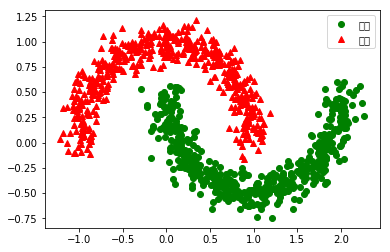

In [115]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label='양성')
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label='음성')
plt.legend()
plt.show()

#### 편향 특성 추가

In [116]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

#### y_train 열 벡터로 변경

In [117]:
y_moons_column_vector = y_moons.reshape(-1, 1)

#### 훈련 세트/테스트 세트 나누기

In [138]:
test_ratio = 0.2
test_size = int(m * test_ratio)

X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

#### 배치 만들기
아래 배치를 생성하는 함수는 훈련 세트에서 랜덤하게 샘플링한다.  
하나의 배치에 중복 샘플이 있을 수 있고 한 번의 에포크에 모든 훈련 샘플이 포함되지 않을 수 있다(사실 샘플의 $\frac{2}{3}$ 정도가 포함된다).  
하지만 실전에서 별 문제가 되지 않고 코드가 간단해진다.

In [139]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

작은 배치 만들어보기

In [140]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  0.01441495,  0.21721282],
       [ 1.        ,  0.10021403,  1.05137369],
       [ 1.        ,  1.12513092,  0.18174901],
       [ 1.        , -1.02798645,  0.3103742 ],
       [ 1.        ,  1.97903238,  0.52900065]])

In [141]:
y_batch

array([[1],
       [0],
       [0],
       [0],
       [1]], dtype=int64)

### (2) 모델 만들기

#### 기본 그래프 리셋

In [142]:
reset_graph()

moons 데이터셋은 두 개의 입력 특성을 가지므로 각 샘플은 평면 위의 한 점이다(즉, 2차원)

In [143]:
n_inputs = 2

#### 로지스틱 회귀 모델 만들기
먼저 (선형 회귀 모델과 동일하게) 입력의 가중치 합을 계산하고 그 결과를 시그모이드 함수에 적용하여 양성 클래스에 대한 추정 확률을 만든다.

$ \hat p = h_{\theta}(ｘ) = \sigma(\theta^T \cdot ｘ) $
* $\theta$ : 편향 $\theta_0$와 가중치 $\theta_1, \theta_2, \dots, \theta_n$을 포함한 파라미터 벡터
* $ｘ$ : 상수항 $x_0 = 1$과 입력 특성 $x_1, x_2, \dots, x_n$을 포함한 입력 벡터

한 번에 여러 샘플에 대한 예측을 만들 수 있어야 하므로 하나의 입력 벡터보다 입력 행렬 $\mathbf X$를 사용 한다.  
$i^{th}$번째 행이 $i^{th}$번째 입력 벡터의 전치$(ｘ^i)^T$이다.  
아래 식을 사용하여 각 샘플의 양성 클래스에 속할 확률을 추정할 수 있다.  

$ \hat p = \sigma(\mathbf X \cdot \theta)$

In [144]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), 
                    name='theta')
logits = tf.matmul(X, theta, name='logits')
# y_proba = 1 / (1 + tf.exp(-logits))
y_proba = tf.sigmoid(logits)

#### 로그 손실
로지스틱 회귀에 사용하기 좋은 비용함수이다.

$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$


1. 로그 손실 직접 구현

In [145]:
epsilon = 1e-7 # 로그 계산 시 오버플로우 피하기 위해
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + 
                       (1 - y) * tf.log(1 - y_proba + epsilon))

2. `tf.losses.log_loss()` 사용하기

In [146]:
loss = tf.losses.log_loss(y, y_proba)  # 기본적으로 epsilon = 1e-7 가 사용된다.

#### 옵티마이저 만들고 비용 함수 최소화 시키기

In [147]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

#### 변수 초기화

In [148]:
init = tf.global_variables_initializer()

#### 훈련

In [149]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("에포크:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

에포크: 0 	Loss: 0.79260236
에포크: 100 	Loss: 0.3434635
에포크: 200 	Loss: 0.30754045
에포크: 300 	Loss: 0.29288894
에포크: 400 	Loss: 0.28533572
에포크: 500 	Loss: 0.28047806
에포크: 600 	Loss: 0.27808294
에포크: 700 	Loss: 0.2761544
에포크: 800 	Loss: 0.27551997
에포크: 900 	Loss: 0.27491233


> **NOTE**  
배치를 만들 때 에포크 수를 사용하지 않았으므로 두 개의 `for` 반복을 중첩하지 않고 하나의 `for` 반복을 사용할 수 있다.  
하지만 훈련 시간을 에포크의 개수로 생각하는게 편리하다(즉, 알고리즘이 훈련 세트를 모두 훑고 지나가는 횟수)

In [151]:
y_proba_val[:5]

array([[0.54895616],
       [0.70724374],
       [0.51900256],
       [0.9911136 ],
       [0.5085905 ]], dtype=float32)

> `y_proba_val`은 해당 샘플이 양성 클래스에 속할 모델의 추정 확률을 담고 있다.

#### 최대 가능도 방법(Maximum Likelihood)을 사용하여 각 샘플 분류하기
추정 확률이 0.5보다 크거나 같으면 양성으로 분류한다.

In [152]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

> 다른 임계값을 사용해야 할 경우가 있다.  
높은 정밀도(대신 낮은 재현율)를 원한다면 임계값을 높이고, 재현율을 높이려면(대신 낮은 정밀도) 임계값을 낮춘다 (3장 참조)

#### 모델의 정밀도, 재현율 계산

In [153]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.8627450980392157

In [154]:
recall_score(y_test, y_pred)

0.8888888888888888

#### 예측에 대한 그래프

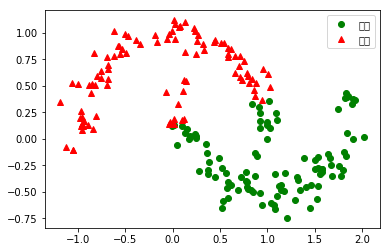

In [155]:
y_pred_idx = y_pred.reshape(-1) # 열 벡터를 1차원 배열로 변환
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label='양성')
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label='음성')
plt.legend()
plt.show()

> 결과가 좋지 않다.  
하지만 로지스틱 회귀 모델은 선형적인 결정 경계를 가지므로 최선에 가까운 것 같다 (특성을 더 추가하지 않는다면)

### (3) 연습문제 부가기능을 추가해서 구현
* (손쉽게 재사용할 수 있도록) `logistic_regression()` 안에 그래프를 정의하세요.
* 훈련하는 동안 `Saver`로 체크포인트를 정기적으로 저장하세요. 그리고 훈련 마지막에 최종 모델을 저장하세요.
* 훈련이 중지되고 다시 시작될 때 마지막 체크포인트를 복원하세요.
* 텐서보드에서 그래프가 일목요연하게 보이도록 이름 범위를 사용해 그래프를 정의하세요.
* 서머리를 추가해 텐서보드에서 학습 곡선을 시각화 해보세요.
* 학습률이나 미니배치 크기같은 하이퍼파라미터를 바꿔보고 학습 곡선의 형태를 살펴보세요.

#### 모델 성능 향상을 위해 특성 추가
연습문제에는 포함되어 있지 않지만 입력에 $x_1^2, x_2^2, x_1^3, x_2^3$ 4개 특성 추가한다.  
여기서는 수동으로 특성을 추가하지만 `sklearn.preprocessing.PolynomialFeatures`를 사용할 수 있다.

In [157]:
X_train_enhanced = np.c_[X_train, 
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

#### 그래프 초기화

In [158]:
reset_graph()

#### 그래프를 만들기 위한 함수 정의
입력 `X`와 타킷 `y`의 정의를 포함하지 않았다.
* 이 함수에서 정의할 수 있지만 그렇게 하지 않아야 다양한 경우에 이 함수를 사용할 수 있다.
    * 예. 로지스틱 회귀 모델에 주입하기 전에 입력에 대해 전처리 단계를 추가하 ㄹ수 있다.

In [165]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope('logistic_regression'):
        with tf.name_scope('model'):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1],
                                               -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name='theta')
            logits = tf.matmul(X, theta, name='logits')
            y_proba = tf.sigmoid(logits)
        with tf.name_scope('train'):
            loss = tf.losses.log_loss(y, y_proba, scope='loss')
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope('init'):
            init = tf.global_variables_initializer()
        with tf.name_scope('save'):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

#### summary를 저장할 로그 디렉토리 이름을 생성하는 함수 만들기

In [166]:
from datetime import datetime

def log_dir(prefix=''):
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    root_logdir = 'tf_logs'
    if prefix:
        prefix += '-'
    name = prefix + 'run-' + now
    return '{}/{}/'.format(root_logdir, name)

#### `logistic_regression()` 함수를 사용해 그래프 만들기

In [167]:
n_inputs = 2 + 4
logdir = log_dir('logreg')

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

드디어 모델을 학습시킬 수 있다.

#### 훈련
이전에 훈련 세션이 중지되었는지부터 검사하고, 그렇다면 체크포인트를 로드하고 저장된 에포크 횟수부터 훈련을 이어간다.  
* 이 예에서는 별도의 파일에 에포크 횟수를 저장했지만 11장에서 모델에 일부로 훈련 스텝을 저장하는 방법을 배운다(예. `global_step`이란 훈련되지 않는 변수를 옵티마이저의 `minimize()` 메서드에 전달한다).

다시 시작할 때 마지막 체크포인트가 제대로 복원되는지 확인하기 위해 훈련을 중지시켜 볼 수 있다.

In [171]:
import os

n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = '/tmp/my_logreg_model.ckpt'
checkpoint_epoch_path = checkpoint_path + '.epoch'
final_model_path = './my_logreg_model'

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # 체크포인트 파일이 있으면 모델을 복원하고 에포크 횟수 로드
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print('중지되었던 훈련입이다. 에포크를 이어값니다.', start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
        
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], 
                                        feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print('에포크 : ', epoch, '\t손실 : ', loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, 'wb') as f:
                f.write(b'%d' % (epoch + 1))
    
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

에포크 :  0 	손실 :  0.6294791
에포크 :  500 	손실 :  0.16108647
에포크 :  1000 	손실 :  0.11897118
에포크 :  1500 	손실 :  0.0972774
에포크 :  2000 	손실 :  0.083749466
에포크 :  2500 	손실 :  0.07437385
에포크 :  3000 	손실 :  0.06752581
에포크 :  3500 	손실 :  0.06225726
에포크 :  4000 	손실 :  0.058033537
에포크 :  4500 	손실 :  0.054592587
에포크 :  5000 	손실 :  0.05173551
에포크 :  5500 	손실 :  0.049303055
에포크 :  6000 	손실 :  0.047174234
에포크 :  6500 	손실 :  0.045370862
에포크 :  7000 	손실 :  0.043779805
에포크 :  7500 	손실 :  0.042379476
에포크 :  8000 	손실 :  0.04110836
에포크 :  8500 	손실 :  0.039951876
에포크 :  9000 	손실 :  0.0388961
에포크 :  9500 	손실 :  0.037979417
에포크 :  10000 	손실 :  0.037118115


#### 예측

In [172]:
y_pred = (y_proba_val >= 0.5)
precision_score(y_test, y_pred)

0.9797979797979798

In [173]:
recall_score(y_test, y_pred)

0.9797979797979798

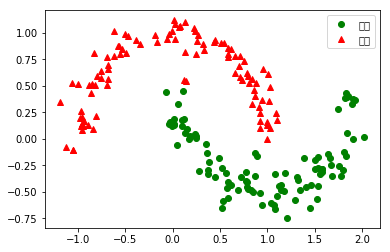

In [174]:
y_pred_idx = y_pred.reshape(-1) # 열 벡터 대신 1차원 배열
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="양성")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="음성")
plt.legend()
plt.show()

> 훨씬 좋아졌다. 새로 추가한 특석이 확실히 도움이 많이 되었다.

#### 텐서보드 서버를 시작해서 학습 곡선 확인해보기
즉, 에포크 횟수에 대해 테스트 세트로 평가한 손실이 얼마나 되는지  
\$ tensorboard --logdir=tf_logs

#### `batch_size`나 `learning_rate` 하이퍼파라미터 랜덤 서치로 조정 후 훈련하면서 학습 곡선 비교
* 간단하게 하기 위해 체크포인트 관리 부분은 제외

In [175]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)
    
    n_inputs = 2 + 4
    logdir = log_dir('logreg')
    
    print("반복", search_iteration)
    print("  logdir:", logdir)
    print("  batch_size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  훈련: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration
    
    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, 
                                                batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], 
                                    feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  정밀도:", precision_score(y_test, y_pred))
        print("  재현율:", recall_score(y_test, y_pred))

반복 0
  logdir: tf_logs/logreg-run-20190114041419/
  batch_size: 53
  learning_rate: 0.004430375245218265
  훈련: .....................
  정밀도: 0.9797979797979798
  재현율: 0.9797979797979798
반복 1
  logdir: tf_logs/logreg-run-20190114041545/
  batch_size: 80
  learning_rate: 0.0017826497151386947
  훈련: .....................
  정밀도: 0.9696969696969697
  재현율: 0.9696969696969697
반복 2
  logdir: tf_logs/logreg-run-20190114041643/
  batch_size: 73
  learning_rate: 0.00203228544324115
  훈련: .....................
  정밀도: 0.9696969696969697
  재현율: 0.9696969696969697
반복 3
  logdir: tf_logs/logreg-run-20190114041754/
  batch_size: 6
  learning_rate: 0.004491523825137997
  훈련: .....................
  정밀도: 0.9801980198019802
  재현율: 1.0
반복 4
  logdir: tf_logs/logreg-run-20190114043002/
  batch_size: 24
  learning_rate: 0.07963234721775589
  훈련: .....................
  정밀도: 0.9801980198019802
  재현율: 1.0
반복 5
  logdir: tf_logs/logreg-run-20190114043256/
  batch_size: 75
  learning_rate: 0.0004634250583294876
 

하이퍼파라미터의 적절한 스케일을 감잡을 수 없을 때 `scipy.stats.reciprocal` 함수를 사용하여 난수 분포를 얻을 수 있다.